In [1]:
import pandas as pd
import numpy as np
import re
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# age_df = pd.read_csv('./data/preprocessed_tweets_with_for_age_pred.csv', lineterminator='\n')
age_df = pd.read_csv('/content/drive/MyDrive/CS640/final_project/preprocessed_tweets_with_for_age_pred.csv', lineterminator='\n')

In [6]:
print(age_df.columns)
len(age_df)

Index(['Unnamed: 0', 'text', 'label', 'screen_name'], dtype='object')


96789

In [8]:
age_df

,Unnamed: 0,text,label,screen_name
0,1,haven talked this girl since sophomore year an...,0,___aleia
1,3,rly try cash app using code and each get dlnxtrw,1,__drewc
2,4,yes but come san marcos and live with,0,__EmilyRice__
3,5,small,1,__ginaaaa__
4,8,what dumb ass petty islanders tweet,1,_AJoseph_
...,...,...,...,...
96784,114487,hey guys live finishing some iron banana stuff...,1,Yoloderr
96785,114491,salt and pepa,1,Yunghatedbelo
96786,114492,this one those open for surprise photos,1,yvonneeruiiz
96787,114496,she missed her st because covid pls,0,ZoeBerrier


In [10]:
age_df['label'].value_counts()

1    60674
0    36115
Name: label, dtype: int64

sample 10000 data from each label

In [11]:
freq = pd.DataFrame({'label':[0, 1],
                     'nostoextract':[10000, 20000], })

def bootstrap(data, freq):
    freq = freq.set_index('label')

    # This function will be applied on each group of instances of the same
    # class in `data`.
    def sampleClass(classgroup):
        cls = classgroup['label'].iloc[0]
        nDesired = freq.nostoextract[cls]
        nRows = len(classgroup)

        nSamples = min(nRows, nDesired)
        return classgroup.sample(nSamples)

    samples = data.groupby('label').apply(sampleClass)

    # If you want a new index with ascending values
    # samples.index = range(len(samples))

    # If you want an index which is equal to the row in `data` where the sample
    # came from
    samples.index = samples.index.get_level_values(1)

    # If you don't change it then you'll have a multiindex with level 0
    # being the class and level 1 being the row in `data` where
    # the sample came from.

    return samples

train_age_df = bootstrap(age_df,freq)


In [13]:
len(train_age_df)

30000

In [12]:
test_age_df = age_df.drop(index = train_age_df.index, axis = 0)
test_freq = pd.DataFrame({'label':[0, 1],
                     'nostoextract':[5000, 5000], })
test_age_df = bootstrap(age_df,test_freq)
len(test_age_df)

10000

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_age_df['text'], train_age_df['label'], test_size=0.3, stratify=train_age_df['label'])

### Age prediction using pre-trained BERT model

In [15]:
!pip install transformers
!pip insrall torch

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 72.8 MB/s 
     |████████████████████████████████| 3.3 MB 78.7 MB/s 
     |████████████████████████████████| 61 kB 663 kB/s 
     |████████████████████████████████| 596 kB 76.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: unknown command "insrall" - maybe you meant "install"


In [16]:
import transformers
import torch
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast

In [17]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-cased', return_dict=False)
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

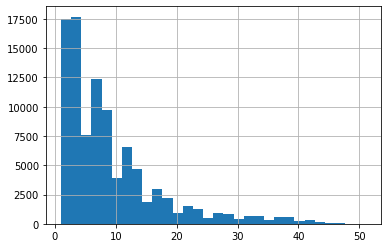

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in age_df['text']]
pd.Series(seq_len).hist(bins = 30)

In [18]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(), 
    max_length = 25,
    padding='max_length', 
    truncation=True,

)

In [19]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(), 
    max_length = 25,
    padding='max_length', 
    truncation=True,

)

In [20]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_age_df['text'].tolist(),
    max_length = 25,
    padding='max_length',
    truncation=True,

)

In [21]:
# Formatting Ys turn [0, 1, 2, 0, 1, 1] to [[1,0,0], [0,1,0], [0, 0, 1], ...]
def label_y2mat(y_ls):
    y_mat = np.zeros((len(y_ls), 3))

    for idx, v in enumerate(y_ls):
        v = int(v)
        y_mat[idx][v] = 1

    return y_mat

In [22]:
## convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_age_df['label'].tolist())

In [23]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 32
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [24]:
class BERT_Arch(nn.Module):
    def __init__(self, bert, n_classes: int,):
        super(BERT_Arch, self).__init__()
        self.bert = bert 
        # dropout layer
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(768, self.bert.config.hidden_size)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)
        self.criterion = nn.NLLLoss(weight=weights) 

        
        
    # define the forward pass    
    def forward(self, sent_id, mask, labels = None):
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
        x = self.fc1(cls_hs)
        x = self.dropout(x)
        x = self.out(x)
        x = self.softmax(x)
        return x


In [25]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y = y_train)
print("Class Weights:",class_weights)


Class Weights: [1.5  0.75]


In [26]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# number of training epochs
epochs = 8

In [27]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert, 2)
# push the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [28]:
# optimizer from hugging face transformers
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(),
lr = 1e-5,
weight_decay=1e-4)          # learning rate

In [29]:
# function to train the model
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    # empty list to save model predictions
    total_preds=[]
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        # clear previously calculated gradients 
        model.zero_grad()        
        
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        loss = model.criterion(preds, labels)

        # add on to the total loss
        total_loss += loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
        
        
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds

In [30]:
# function for evaluating the model
def evaluate():
    print("\nEvaluating...")
    # deactivate dropout layers
    model.eval()
    total_loss, total_accuracy = 0, 0
    # empty list to save the model predictions
    total_preds = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        # Progress update every 50 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            #elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        # push the batch to gpu
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds = model(sent_id, mask)
            # compute the validation loss between actual and predicted values
            loss = model.criterion(preds,labels)
            total_loss += loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
        
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

In [31]:
# set initial loss to infinite
best_valid_loss = float('inf')
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 8
  Batch    50  of    657.
  Batch   100  of    657.
  Batch   150  of    657.
  Batch   200  of    657.
  Batch   250  of    657.
  Batch   300  of    657.
  Batch   350  of    657.
  Batch   400  of    657.
  Batch   450  of    657.
  Batch   500  of    657.
  Batch   550  of    657.
  Batch   600  of    657.
  Batch   650  of    657.

Evaluating...
  Batch    50  of    282.
  Batch   100  of    282.
  Batch   150  of    282.
  Batch   200  of    282.
  Batch   250  of    282.

Training Loss: 0.705
Validation Loss: 0.689

 Epoch 2 / 8
  Batch    50  of    657.
  Batch   100  of    657.
  Batch   150  of    657.
  Batch   200  of    657.
  Batch   250  of    657.
  Batch   300  of    657.
  Batch   350  of    657.
  Batch   400  of    657.
  Batch   450  of    657.
  Batch   500  of    657.
  Batch   550  of    657.
  Batch   600  of    657.
  Batch   650  of    657.

Evaluating...
  Batch    50  of    282.
  Batch   100  of    282.
  Batch   150  of    282.
  Batch   200

In [33]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds_prob = preds.detach().cpu().numpy()

# model's performance
preds = np.argmax(preds_prob, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.55      0.63      0.58      5000
           1       0.56      0.48      0.52      5000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



In [35]:
assert len(test_age_df) == len(preds_prob)

test_age_df['age_pred'] = preds
test_age_df['pred_prob_0'] = preds_prob[:, 0]
test_age_df['pred_prob_1'] = preds_prob[:, 1]

test_age_df

,Unnamed: 0,text,label,screen_name,age_pred,pred_prob_0,pred_prob_1
81482,95238,what the reason kindly fuck off,0,jay_littell99,0,-0.609488,-0.784449
12760,14152,slur,0,sapphiceevee,0,-0.652931,-0.735049
30109,33880,yeah,0,erin_belle_,0,-0.588137,-0.810493
76803,89400,manifest great things tonight,0,Amandabookk,1,-0.721628,-0.665455
66755,77151,really easy say all these words but you not ac...,0,serkif,1,-0.836983,-0.567422
...,...,...,...,...,...,...,...
79100,92226,did say virtually,1,DocHoIIiday,0,-0.638387,-0.751081
46535,53017,got first session tomorrow and,1,Lil_OSO97,0,-0.635889,-0.753884
14908,16545,sunday funday,1,TheeHenryAdjah,1,-0.713750,-0.672960
75278,87501,just college bro every fucking party went too ...,1,StylezxGaming,0,-0.593784,-0.803484


In [37]:
test_age_df.to_csv('/content/drive/MyDrive/CS640/final_project/tweets_age_pred_prob.csv', index=False)